In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Read Data

Read printer data into a DataFrame and subset it into those that already have VIAF IDs and those that don't. 

Plot total texts, texts with IDs, texts without IDs

In [3]:
printers_data_file = 'data/pre_1655_printers.csv'
printers_df = pd.read_csv(printers_data_file)

viaf_exists = printers_df[~printers_df['Entity Identifiers Column'].isna()]
viaf_needed = printers_df[printers_df['Entity Identifiers Column'].isna()]

Total Number of texts:  31,569
Texts with VIAF IDs:    15,947
Texts without VIAF IDs: 15,622


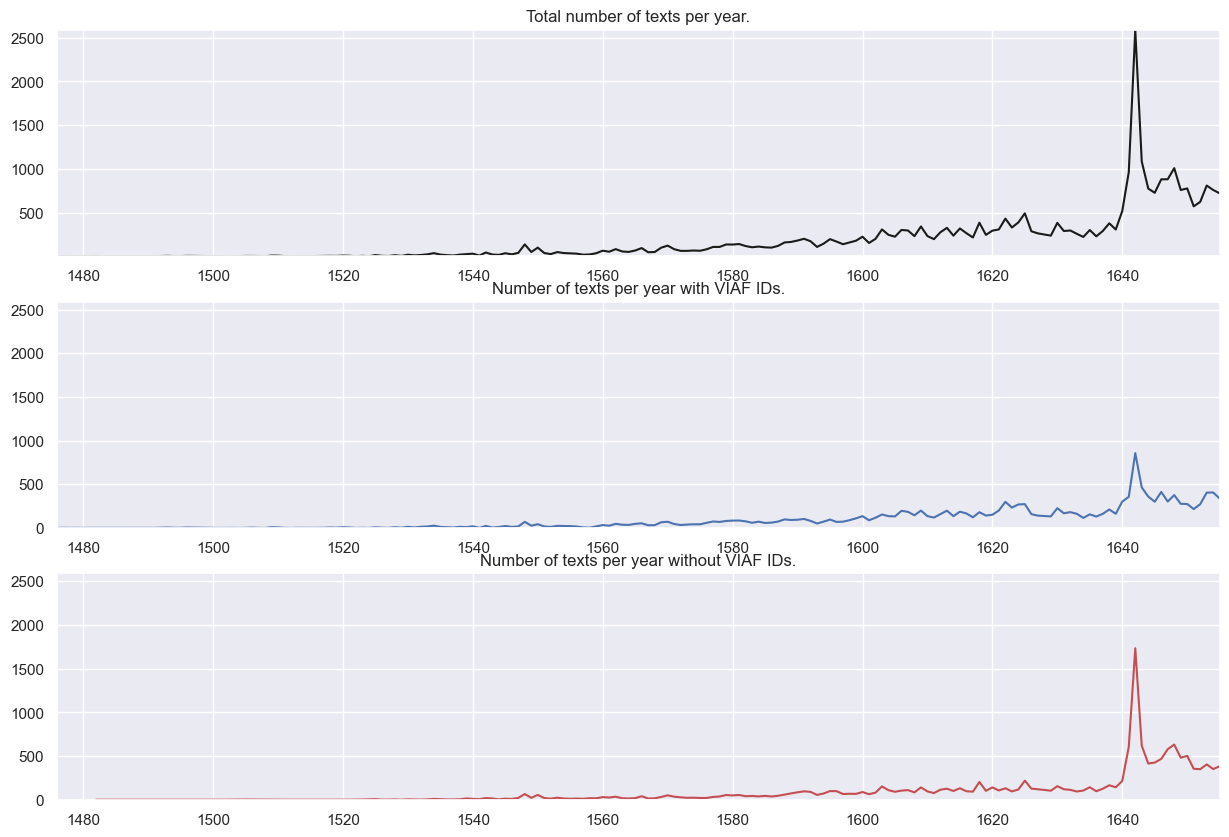

In [4]:
# Change these values to zoom in on shorter yearspans
start_year = 1400
end_year = 1660

total_counts = printers_df.groupby(['parsed_year'])['parsed_year'].count()
viaf_exists_counts = viaf_exists.groupby(['parsed_year'])['parsed_year'].count()
viaf_needed_counts = viaf_needed.groupby(['parsed_year'])['parsed_year'].count()

# Set up the plot
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,10))
grid = plt.GridSpec(3,1)
axes = [fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[1, 0]), fig.add_subplot(grid[2, 0])]

sns.lineplot(data=total_counts, x=total_counts.index, y=total_counts.values, color='k', ax=axes[0])
sns.lineplot(data=viaf_exists_counts, x=viaf_exists_counts.index, y=viaf_exists_counts.values, color='b', ax=axes[1])
sns.lineplot(data=viaf_needed_counts, x=viaf_needed_counts.index, y=viaf_needed_counts.values, color='r', ax=axes[2])

start_year = start_year if total_counts.index[0] < start_year else total_counts.index[0]
end_year = end_year if total_counts.index[-1] > end_year else total_counts.index[-1]
axes[0].set(xlim=(start_year, end_year), ylim=(1, max(total_counts.values)), xlabel=None, title='Total number of texts per year.')
axes[1].set(xlim=(start_year, end_year), ylim=(0, max(total_counts.values)), xlabel=None, title='Number of texts per year with VIAF IDs.')
axes[2].set(xlim=(start_year, end_year), ylim=(0, max(total_counts.values)), xlabel=None, title='Number of texts per year without VIAF IDs.')

print('Total Number of texts:  {:,}\nTexts with VIAF IDs:    {:,}\nTexts without VIAF IDs: {:,}'\
          .format(len(printers_df), len(viaf_exists), len(viaf_needed)))

# Parse Printer Names

Parse printer names in the VIAF needed dataframe to identify those most likely to be names. This can likely be done with some basic regex patterns that look for firstname/initial lastname/initial patterns. Once these names are identified, we'll try to cluster them to find potential variants that should be mapped on to the same name. 

In [5]:
viaf_needed

,tcpid,role,name,name #2,Entity Identifiers Column,title,author,parsed_year,notBefore,notAfter,year,publicationStmt
9,A05603,printer,[s] lettou [et] Will[es] de machlinia i citate...,[s] lettou [et] Will[es] de machlinia i citate...,NaN,Tenannt en fee simple est celuy ...,"Littleton, Thomas, Sir, d. 1481.",1482,NaN,NaN,[1482]],Imp[re]ssi p[er] nos Ioh[an]e[s] lettou [et] W...
14,A06558,printer,Wyllyam Caxton,William Caxton,NaN,[The lyf of our lady],"Lydgate, John, 1370?-1451?",1484,NaN,NaN,1484],"Enprynted by Wyllyam Caxton, [Westminster : 1484]"
48,A97376,publisher,Nicholas Lecomte,Nicholas Lecomte,NaN,Hore beate marie virginis secundum vsum Sarum,Catholic Church.,1498,NaN,NaN,1498],"I. Iehannot [for Nicholas Lecomte, [Paris] : 1..."
56,A23592,printer,"one some tyme scole mayster of saynt Albons, v...","one some tyme scole mayster of saynt Albons, v...",NaN,Tabula,"Higden, Ranulf, d. 1364. Polycronicon. English...",1502,NaN,NaN,[1502]],[Enprynted by one some tyme scole mayster of s...
61,A19314,printer,Wynkyn de Warde [sic],Wynkyn de Warde,NaN,[The complaint of them that be too late married],"Gringore, Pierre, ca. 1475-1538?",1505,NaN,NaN,[1505?]],Empre[n]ted in fletestrete by Wynkyn de Warde ...
...,...,...,...,...,...,...,...,...,...,...,...,...
31557,B17645,printer,I.C.,I.C.,NaN,Of the eternity of Gods election the certainty...,"Bennett, John, a servant of Christ and his chu...",1655,NaN,NaN,1655,"Printed by I.C. for Livewel Chapman, London : ..."
31560,B19634,publisher,John Wright the younger,John Wright the younger,NaN,"Cupids wanton wiles: or, The young mans friend...","L. P. (Laurence Price), fl. 1625-1680?",1655,NaN,NaN,[ca. 1655],"for John Wright the younger, dwelling in the O..."
31562,B20843,printer,Iohn Field,John Field,NaN,"Wednesday, February 13, 1655, at the council a...",England and Wales. Lord Protector (1653-1658 :...,1655,NaN,NaN,1655,"Printed by Henry Hills, and Iohn Field, Printe..."
31564,B20857,printer,Iohn Fields,Iohn Fields,NaN,"By the Protector, a proclamation giving encour...",England and Wales. Lord Protector (1653-1658 :...,1655,NaN,NaN,MDCLV [1655],"Printed by Henry Hills and Iohn Fields ..., Lo..."


## Some early Exploration about common misspellings into the database
These numbers may be low but remember this is of the names that have not already been asigned a identifier (i.e. half the database)

So far I compared John-Iohn, William-Wyllyam, and counted number of "me "

In [6]:

#compare john to iohn
#create a mask for john and John
john_mask = viaf_needed["name"].str.contains("John", case=False)
#count the number of times the mask evaluated to true
john_count = john_mask.sum()
#create a mask for iohn and Iohn
iohn_mask = viaf_needed["name"].str.contains("Iohn", case=False)
#count the number of times the mask evaluated to true
iohn_count = iohn_mask.sum()
print(f"Number of occurrences of 'John' or 'john': {john_count} \n Number of occurrences of 'Iohn' or 'iohn': {iohn_count}")
#compare william to wyllyam (same procedure as above)
will_mask = viaf_needed["name"].str.contains("William", case=False)
will_count = will_mask.sum()
wyyll_mask = viaf_needed["name"].str.contains("Wyllyam", case=False)
wyll_count = wyyll_mask.sum()
print(f"Number of occurrences of 'William' or 'william': {will_count} \n Number of occurrences of 'Wyllyam' or 'wyllyam': {wyll_count}")
#number of occurences of "me " at beginning of name
# Define a regular expression pattern to match "me " at the beginning of each cell. ^ = beginning of the text
pattern = r"^me "
# Count the number of times the pattern occurs in each cell of the "name" column
counts = viaf_needed["name"].str.count(pattern)
# Sum the count of pattern occurrences to get the total count
total_count = counts.sum()
# Print the total count
print("Number of occurrences of 'me ' at the beginning of each cell:", total_count)



Number of occurrences of 'John' or 'john': 1024 
 Number of occurrences of 'Iohn' or 'iohn': 1437
Number of occurrences of 'William' or 'william': 637 
 Number of occurrences of 'Wyllyam' or 'wyllyam': 30
Number of occurrences of 'me ' at the beginning of each cell: 53
